In [61]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import numpy as np
from torch.utils.data import DataLoader

# !!!
from model_regression import MixingModel
from dataset import MultitrackAudioDataset
from medleydb_split import train_songlist, test_songlist

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

print(torch.backends.cudnn.version())
torch.backends.cudnn.benchmark = True

Torch version:  1.4.0
Device:  cuda
7603


In [5]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
weights_dir = './weights'
seed = 321
chunk_length = 1

In [6]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=train_songlist,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='train',
    seed=seed
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=['TheDistricts_Vermont'],
    chunk_length=chunk_length,
    train_val_test_split=(0.0, 1.0, 0.0),
    mode='val',
    seed=seed
)

d_test = MultitrackAudioDataset(
    base_path,
    songlist=test_songlist,
    chunk_length=chunk_length,
    train_val_test_split=(0.0, 0.0, 1.0),
    mode='test',
    seed=seed
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))
print('Test: {} tracks, {} chunks'.format(d_test.get_num_songs(), len(d_test)))

Train: 29 tracks, 7775 chunks
Val: 1 tracks, 228 chunks
Test: 31 tracks, 3243 chunks


Train features shape:  (4, 128, 44)
-3.368032 1.5059105
[[-1.4300183  -1.7776802  -1.8326229  ... -1.807336   -2.096509
  -1.1582878 ]
 [-0.8905518  -1.1009231  -1.2734     ... -0.95045584 -1.0422982
   0.23559323]
 [-1.2152505  -0.806028   -1.0109689  ... -0.6332522  -0.43582052
   0.9216894 ]
 ...
 [-2.9206672  -2.8177054  -2.8592644  ... -2.6215487  -2.9032638
  -2.9721885 ]
 [-2.9206672  -2.8177054  -2.8592644  ... -2.6215487  -2.9032638
  -2.9721885 ]
 [-2.9206672  -2.8177054  -2.8592644  ... -2.6215487  -2.9032638
  -2.9721885 ]]
(128, 44)
------------------------------------------------------------
-0.31071678 1.0
[[ 0.8473      0.6442744   0.67581713 ...  0.4148077   0.39078438
   0.44615123]
 [ 1.          0.9315523   0.95059854 ...  1.          1.
   0.96610254]
 [ 0.81082225  0.8161503   0.8286334  ...  0.9991839   0.94420874
   1.        ]
 ...
 [-0.23544772 -0.24274103 -0.26096982 ... -0.2503945  -0.24489005
  -0.21793489]
 [-0.23544772 -0.24274103 -0.26096982 ... -0.25039

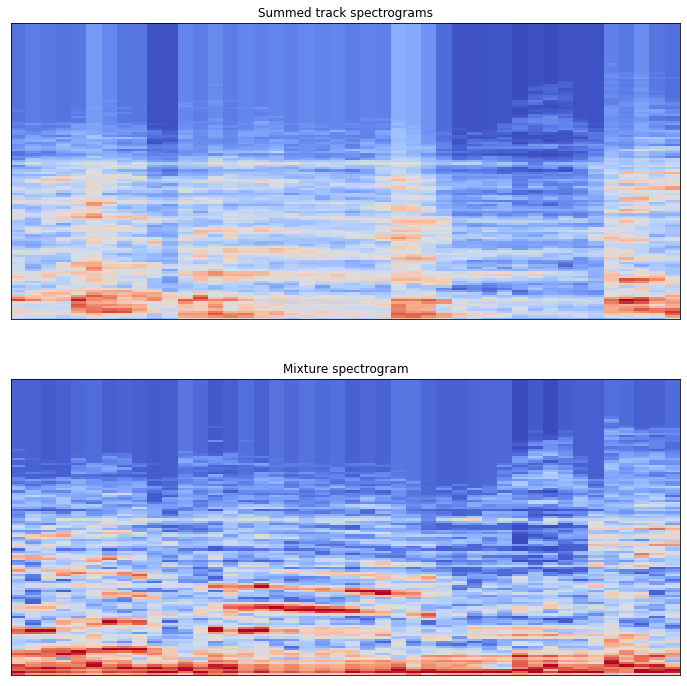

In [7]:
plt.figure(figsize=(12, 12))

sample = d_val[20]

print('Train features shape: ', sample['train_features'].shape)

summed_spec = sample['train_features'].sum(axis=0)

print(np.min(summed_spec), np.max(summed_spec))
print(summed_spec)

print(summed_spec.shape)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(summed_spec)
plt.title('Summed track spectrograms')

# -----------------------------------------------------------------
print('-' * 60)

print(np.min(sample['gt_features']), np.max(sample['gt_features']))
print(sample['gt_features'])

print(sample['gt_features'].shape)
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(sample['gt_features'])
plt.title('Mixture spectrogram')

plt.show()

In [ ]:
for i in range(len(d)):
    print('CHUNK: {}'.format(i))
    print('---------------')
    sample = d[i]
    if i == 20:
#         print(sample['drums_feature'].shape)
#         librosa.display.specshow(sample['mixture_feature'])
        ipd.Audio(sample['drums_audio'], rate=44100)
        print('---------------')
        break

In [8]:
train_loader = DataLoader(d_train, batch_size=32, shuffle=False,
                          num_workers=0, collate_fn=None,
                          pin_memory=False, drop_last=False, timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val, batch_size=228, shuffle=False,
                        num_workers=0, collate_fn=None,
                        pin_memory=True, drop_last=True, timeout=0,
                        worker_init_fn=None)

test_loader = DataLoader(d_test, batch_size=32, shuffle=False,
                        num_workers=0, collate_fn=None,
                        pin_memory=False, drop_last=False, timeout=0,
                        worker_init_fn=None)

---
### Defining and training the model

In [118]:
model = MixingModel().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

227384 trainable parameters


In [119]:
model(torch.Tensor(d_train[100]['train_features'][np.newaxis, :]).to(device))

(tensor([[[-0.6080, -2.9367, -2.8800,  ..., -3.4503, -2.7984,  0.0166],
          [ 1.1393,  0.7681, -0.5505,  ..., -0.1668, -0.1640,  2.3403],
          [ 2.1318,  0.9748,  0.0696,  ...,  0.8190,  0.2857,  2.4959],
          ...,
          [-3.4337, -3.2067, -3.1908,  ..., -3.7349, -3.2087, -3.2896],
          [-3.4337, -3.2067, -3.1908,  ..., -3.7349, -3.2087, -3.2896],
          [-3.4337, -3.2067, -3.1908,  ..., -3.7349, -3.2087, -3.2896]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 (tensor([[0.4369]], device='cuda:0', grad_fn=<AddmmBackward>),
  tensor([[0.1394]], device='cuda:0', grad_fn=<AddmmBackward>),
  tensor([[0.4437]], device='cuda:0', grad_fn=<AddmmBackward>),
  tensor([[-0.2140]], device='cuda:0', grad_fn=<AddmmBackward>)))

In [81]:
weights = './weights/mixmodel2_1s_bs1023_0030_90.679.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [120]:
# criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

In [121]:
def train_model(start_epoch, num_epochs):
    loss_hist = []

    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0

        for i, batch in enumerate(val_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            masked, masks = model(batch['train_features'].to(device))
    #         print(masked.shape)
    #         print(masks[0][0].shape)
    #         print(masks[0])
            masked_np = masked[0].cpu().detach().numpy()
            librosa.display.specshow(masked_np)

            loss = criterion(masked, batch['gt_features'].to(device))
            loss.backward()
            optimizer.step()

            each_n_batches = 1
            if i % each_n_batches == each_n_batches - 1:
                print('[%d, %4d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))

            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(val_loader)
        print('Epoch {} loss: {}\n'.format(epoch + 1, avg_epoch_loss))
        loss_hist.append(avg_epoch_loss)
    
    return loss_hist

[1,    1] loss: 2.852
Epoch 1 loss: 2.851926803588867

[2,    1] loss: 2.110
Epoch 2 loss: 2.1098005771636963

[3,    1] loss: 1.510
Epoch 3 loss: 1.5096721649169922

[4,    1] loss: 1.079
Epoch 4 loss: 1.0792620182037354

[5,    1] loss: 1.009
Epoch 5 loss: 1.0088958740234375

[6,    1] loss: 0.786
Epoch 6 loss: 0.785548210144043

[7,    1] loss: 0.636
Epoch 7 loss: 0.6363357901573181

[8,    1] loss: 0.642
Epoch 8 loss: 0.6416584253311157

[9,    1] loss: 0.557
Epoch 9 loss: 0.5574167966842651

[10,    1] loss: 0.574
Epoch 10 loss: 0.5742127895355225

[11,    1] loss: 0.495
Epoch 11 loss: 0.49543315172195435

[12,    1] loss: 0.478
Epoch 12 loss: 0.47790682315826416

[13,    1] loss: 0.399
Epoch 13 loss: 0.3985462188720703

[14,    1] loss: 0.389
Epoch 14 loss: 0.3891105055809021

[15,    1] loss: 0.380
Epoch 15 loss: 0.3802478015422821

[16,    1] loss: 0.350
Epoch 16 loss: 0.3498285412788391

[17,    1] loss: 0.345
Epoch 17 loss: 0.3451465666294098

[18,    1] loss: 0.337
Epoch 18 

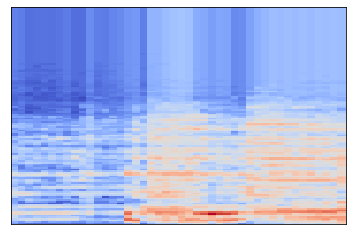

In [122]:
start_epoch = 0
num_epochs = 30
loss_hist = train_model(start_epoch, num_epochs)

In [12]:
weights_file = os.path.join(weights_dir, 'mixmodel2bn_1s_{:04d}_{:.3f}.pt'.format(20, 0.1508)) 
torch.save(model.state_dict(), weights_file)

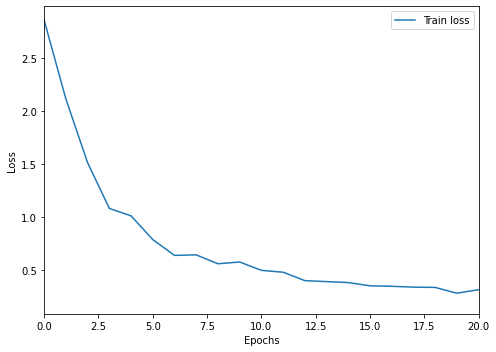

In [123]:
plt.figure(figsize=(7,5))
plt.plot(loss_hist, label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 0 + 20)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))